# GANs for the MNIST dataset

In this notebook we will implement a generative adversarial network (GAN) for generating digits resembling those from the MNIST data set.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## GANs on a nutshell

Next, we will define some hyperparameters and config options

## GANs on MNIST

### Plotting function

In [2]:
# De-normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def plot_result(generator, noise, num_epoch=1, save=False, save_dir='MNIST_GAN_results/', show=True, fig_size=(5, 5)):
    generator.eval()

    noise = noise.to("cuda")
    gen_image = generator(noise)
    gen_image = denorm(gen_image)


    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        ax.imshow(img.cpu().data.view(image_size, image_size).numpy(), cmap='gray', aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = 'Epoch {0}'.format(num_epoch+1)
    fig.text(0.5, 0.04, title, ha='center')
    
    plt.show()

In [3]:
image_size = 28
batch_size = 128
Gn_hidden = [256, 512, 1024]
Dn_hidden = Gn_hidden
dim_z = 100
lr = 0.0002
n_out = 28*28
num_epochs = 60

### Get the data

We are going to load the dataset. Since the MNIST dataset is very popular, PyTorch already has it included into datasets.MNIST, and will automatically download it the first time. We can also specify some transformations, like converting the matrix to a tensor and normalize the pixels

Note that we create two data loaders: one for the training set and another one for the testing set. Since this is just a quick experiment, we are not going to validate the initial hyperparameters, so we don't create another data loader for a validation set.

The main benefit of the DataLoader class is that it creates an object which can be used in a for loop, as we did in the previous train function, to iterate over the minibatches.

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=batch_size, shuffle=True)


Let's visualize some examples together with the true labels.

In [5]:
examples = enumerate(train_loader)
batch_idx, (example, label) = next(examples)
example.shape

torch.Size([128, 1, 28, 28])

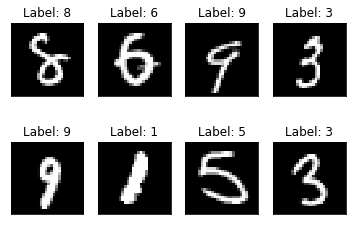

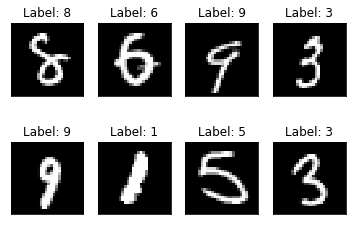

In [6]:
fig = plt.figure()
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(example[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(label[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Model Definition

In [7]:
class Generator(nn.Module):
    def __init__(self, Gn_hidden, dim_z, nout):
        super(Generator, self).__init__()
        self.lin1 = nn.Linear(dim_z, Gn_hidden[0])
        self.lin2 = nn.Linear(Gn_hidden[0], Gn_hidden[1])
        self.lin3 = nn.Linear(Gn_hidden[1], Gn_hidden[2])
        self.lin4 = nn.Linear(Gn_hidden[2], n_out)

    def forward(self, z):
        h = F.relu(self.lin1(z))
        h = F.relu(self.lin2(h))
        h = F.relu(self.lin3(h))
        x = F.tanh( self.lin4(h) )
        return x

class Discriminator(nn.Module):
    def __init__(self, Dn_hidden, n_out
                ):
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(n_out, Dn_hidden[0])
        self.lin2 = nn.Linear(Dn_hidden[0], Dn_hidden[1])
        self.lin3 = nn.Linear(Dn_hidden[1], 1)

    def forward(self, x):
        h = F.relu(self.lin1(x))
        h = F.relu(self.lin2(h))
        v = F.sigmoid(self.lin3(h)) ## Sigmoid in the loss
        return v
    
# Generator model
class Generator(torch.nn.Module):
    def __init__(self, hidden_dims, input_dim, output_dim):
        super(Generator, self).__init__()

        # Hidden layer
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(hidden_dims)):
            # Fully-connected layer
            fc_name = 'fc' + str(i+1)
            if i == 0:
                self.hidden_layer.add_module(fc_name, torch.nn.Linear(input_dim, hidden_dims[i], bias=True))
            else:
                self.hidden_layer.add_module(fc_name, torch.nn.Linear(hidden_dims[i-1], hidden_dims[i], bias=True))
            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential(
            torch.nn.Linear(hidden_dims[i], output_dim, bias=True),
            torch.nn.Tanh()
        )

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out


# Discriminator model
class Discriminator(torch.nn.Module):
    def __init__(self, hidden_dims, n_out):
        super(Discriminator, self).__init__()
        input_dim = n_out
        # Hidden layer
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(hidden_dims)):
            # Fully-connected layer
            fc_name = 'fc' + str(i + 1)
            if i == 0:
                self.hidden_layer.add_module(fc_name, torch.nn.Linear(input_dim, hidden_dims[i], bias=True))
            else:
                self.hidden_layer.add_module(fc_name, torch.nn.Linear(hidden_dims[i-1], hidden_dims[i], bias=True))
            # Activation
            act_name = 'act' + str(i + 1)
            self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))
            # Dropout
            drop_name = 'drop' + str(i + 1)
            self.hidden_layer.add_module(drop_name, torch.nn.Dropout(0.3))

        # Output layer
        self.output_layer = torch.nn.Sequential(
            torch.nn.Linear(hidden_dims[i], 1, bias=True),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out

### GAN Loss Definition

In [9]:
gen = Generator(Gn_hidden, dim_z, n_out).to("cuda")
disc = Discriminator(Dn_hidden, n_out).to("cuda")
##
gen_optimizer = optim.Adam(gen.parameters(), lr=lr)
disc_optimizer = optim.Adam(disc.parameters(), lr=lr)

#### Minimax

In [10]:
disc_avg_losses = []
gen_avg_losses = []
num_test_samples = 5*5
fixed_noise = torch.randn(num_test_samples, dim_z)
bce = torch.nn.BCELoss()

Epoch [1/60], Step [1/469], D_loss: 1.3992, G_loss: -1.4002


/home/roi/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:1330: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


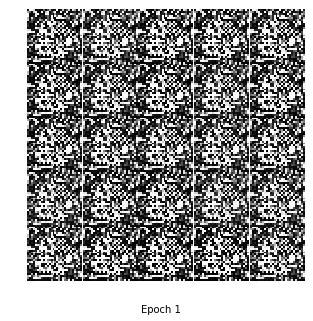

Epoch [2/60], Step [1/469], D_loss: 0.0000, G_loss: -0.0001


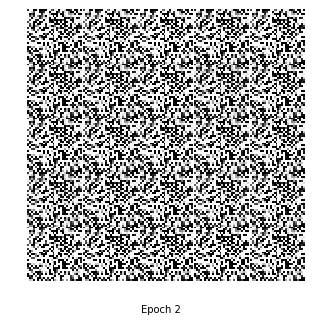

Epoch [3/60], Step [1/469], D_loss: 0.0000, G_loss: -0.0000


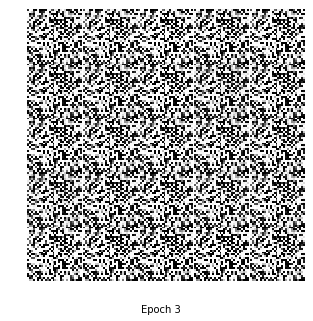

Epoch [4/60], Step [1/469], D_loss: 0.0000, G_loss: -0.0000


KeyboardInterrupt: 

In [11]:
disc_avg_losses = []
gen_avg_losses = []
num_test_samples = 5*5
fixed_noise = torch.randn(num_test_samples, dim_z)
bce = torch.nn.BCELoss()
##
for epoch in range(num_epochs):
    
    disc_losses = []
    gen_losses = []

    # minibatch training
    for i, (images, _) in enumerate(train_loader):

        # image data
        batch_size = images.size()[0]
        x_ = images.view(-1, n_out).to("cuda")

        # labels
        y_real_ = torch.ones(batch_size, 1).to("cuda")
        y_fake_ = torch.zeros(batch_size, 1).to("cuda")

        # Train discriminator with real data
        disc_real_decision = disc(x_)
        disc_real_loss = bce(disc_real_decision, y_real_)
        
        # Train discriminator with fake data
        zmodel = torch.randn(batch_size, dim_z).to("cuda")
        gen_image = gen(zmodel)
        disc_fake_decision = disc(gen_image)
        disc_fake_loss = bce(disc_fake_decision, y_fake_)
        
        disc_loss = disc_real_loss + disc_fake_loss
        ## Take grads
        disc.zero_grad()
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        # Train generator
        zmodel = torch.randn(batch_size, dim_z).to("cuda")
        gen_image = gen(zmodel)
        disc_fake_decision = disc(gen_image)
        disc_fake_loss = bce(disc_fake_decision, y_fake_)

        gen_loss = -( disc_fake_loss + disc_real_loss )

        # Back propagation
        disc.zero_grad()
        gen.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # loss values
        disc_losses.append(disc_loss.data)
        gen_losses.append(gen_loss.data)
        
        if i%1000==0:
            print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), disc_loss.data, gen_loss.data))

    disc_avg_loss = torch.mean(torch.FloatTensor(disc_losses))
    gen_avg_loss = torch.mean(torch.FloatTensor(gen_losses))

    # avg loss values for plot
    disc_avg_losses.append(disc_avg_loss)
    gen_avg_losses.append(gen_avg_loss)


    # Show result for fixed noise
    plot_result(gen, fixed_noise, epoch, save=False, fig_size=(5, 5))


#### Heuristic Loss

In [8]:
gen = Generator(Gn_hidden, dim_z, n_out).to("cuda")
disc = Discriminator(Dn_hidden, n_out).to("cuda")
##
gen_optimizer = optim.Adam(gen.parameters(), lr=lr)
disc_optimizer = optim.Adam(disc.parameters(), lr=lr)

Epoch [1/60], Step [1/469], D_loss: 1.3885, G_loss: 0.7090


/home/roi/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:1330: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


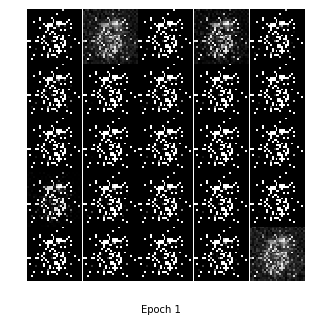

Epoch [2/60], Step [1/469], D_loss: 0.0465, G_loss: 6.9131


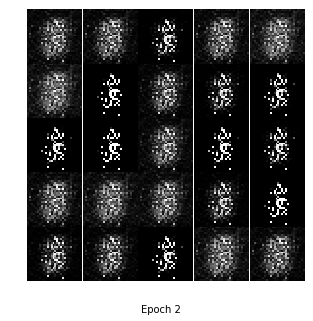

Epoch [3/60], Step [1/469], D_loss: 0.1901, G_loss: 6.6949


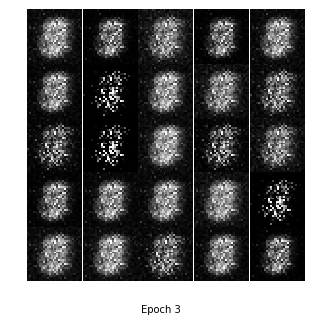

Epoch [4/60], Step [1/469], D_loss: 1.0312, G_loss: 1.8263


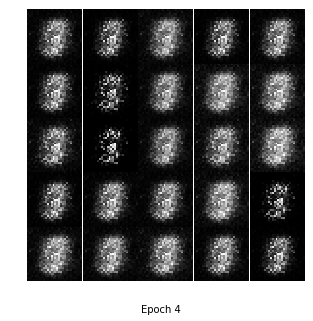

Epoch [5/60], Step [1/469], D_loss: 1.3227, G_loss: 1.0966


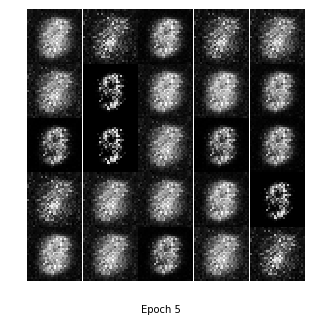

Epoch [6/60], Step [1/469], D_loss: 1.2483, G_loss: 1.2887


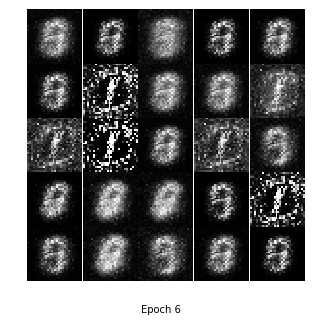

Epoch [7/60], Step [1/469], D_loss: 0.7035, G_loss: 2.5497


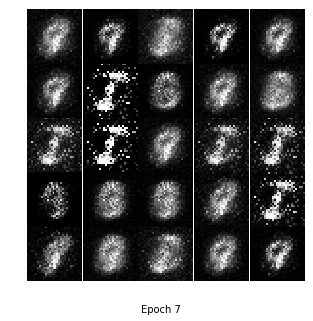

Epoch [8/60], Step [1/469], D_loss: 0.9088, G_loss: 1.6397


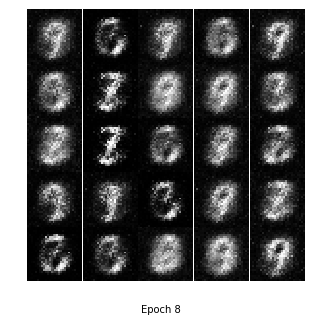

Epoch [9/60], Step [1/469], D_loss: 0.6144, G_loss: 2.1803


In [ ]:
disc_avg_losses = []
gen_avg_losses = []
num_test_samples = 5*5
fixed_noise = torch.randn(num_test_samples, dim_z)
bce = torch.nn.BCELoss()
for epoch in range(num_epochs):
    
    disc_losses = []
    gen_losses = []

    # minibatch training
    for i, (images, _) in enumerate(train_loader):

        # image data
        batch_size = images.size()[0]
        x_ = images.view(-1, n_out).to("cuda")

        # labels
        y_real_ = torch.ones(batch_size, 1).to("cuda")
        y_fake_ = torch.zeros(batch_size, 1).to("cuda")

        # Train discriminator with real data
        disc_real_decision = disc(x_)
        disc_real_loss = bce(disc_real_decision, y_real_)
        
        # Train discriminator with fake data
        zmodel = torch.randn(batch_size, dim_z).to("cuda")
        gen_image = gen(zmodel)
        disc_fake_decision = disc(gen_image)
        disc_fake_loss = bce(disc_fake_decision, y_fake_)
        
        disc_loss = disc_real_loss + disc_fake_loss
        ## Take grads
        disc.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # Train generator
        zmodel = torch.randn(batch_size, dim_z).to("cuda")
        gen_image = gen(zmodel)

        disc_fake_decision = disc(gen_image)
        gen_loss = bce(disc_fake_decision, y_real_)

        # Back propagation
        disc.zero_grad()
        gen.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # loss values
        disc_losses.append(disc_loss.data)
        gen_losses.append(gen_loss.data)
        
        if i%1000==0:
            print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), disc_loss.data, gen_loss.data))

    disc_avg_loss = torch.mean(torch.FloatTensor(disc_losses))
    gen_avg_loss = torch.mean(torch.FloatTensor(gen_losses))

    # avg loss values for plot
    disc_avg_losses.append(disc_avg_loss)
    gen_avg_losses.append(gen_avg_loss)


    # Show result for fixed noise
    plot_result(gen, fixed_noise, epoch, save=False, fig_size=(5, 5))
